# A Multiagent transportation system

Auteur : Philippe Mathieu, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Corwin Fèvre (CRISTAL/SMAC , CRISTAL/OSM)

Creation : 15/01/2020


## Principe général


Cette feuille fait suite à [mas_basics_fr.ipynb](mas_basics_fr.ipynb) qui donnait les bases de la construction d'un système multi-agents sur un reseau social.
Nous vous montrons ici, comment réaliser une petite simulation d'un système de co-voiturage à l'aide des agents.

## Un système séquentiel

Dans sa forme la plus simple, un agent est une entité dotée d'une seule
capacité, celle de décider quoi faire. Personne ne lui indique ce qu'il doit faire,
c'est lui qui décide ! C'est le principe d'**autonomie**. Il suffit juste de lui donner la
parole pour qu'il agisse. Lors de sa prise de parole, l'agent réalise sémantiquement 3 étapes différentes : la **perception** de son entourage, la **decision** en fonction de son propre état et de ce qu'il a perçu, puis l'**action** effective qu'il réalise in fine. Idéalement chaque agent ne peut faire qu'une seule action lors de sa prise de parole.

In [289]:
class Agent:
      def __init__(self,name) :
          self.name=name
        
      def decide(self):
          print("Bonjour ! My name is "+self.name)

Il est bien sûr possible de créer plusieurs agents et de les interroger directement.

In [290]:
a1 = Agent("philippe")
a2 = Agent("corwin")
a1.decide()
a2.decide()

Bonjour ! My name is philippe
Bonjour ! My name is corwin


### Le système multiagent séquentiel

Bien évidemment, un système multi-agent utilise des dizaines voire des
milliers d'agents. Il est alors necessaire de créer une classe
permettant de les manager. En général la méthode qui lance la
simulation se nomme `run` et prend en paramètre le nombre de prises de
paroles.
Afin d'assurer le principe d'**équité** on s'assure que chaque agent a
au moins une fois la parole avant qu'un autre agent ne l'ait deux
fois. On s'appuie pour cela sur la notion de tour de parole. Chaque tour de
parole donne aléatoirement la parole à l'ensemble des agents, avant de
recommencer. Un tour de parole constitue sémantiquement une unité de temps, un tick d'horloge. La classe SMA s'écrit :


In [291]:
import random
class SMA:
      def __init__(self):
        self.tick=0
        self.resetTicks()
        self.agentList = []

      def resetTicks(self):
          tick=0
          
      def addAgent(self,ag):
          self.agentList.append(ag)
 
      def run(self,rounds):
          for i in range(0,rounds):
              self.runOnce()

      def runOnce(self):
          self.tick+=1
          random.shuffle(self.agentList)
          for ag in self.agentList :
              ag.decide()
          print("tick "+str(self.tick)+" ended")

In [292]:
sma = SMA()
sma.addAgent(Agent("paul"))
sma.addAgent(Agent("kim"))
sma.run(6)

Bonjour ! My name is paul
Bonjour ! My name is kim
tick 1 ended
Bonjour ! My name is paul
Bonjour ! My name is kim
tick 2 ended
Bonjour ! My name is kim
Bonjour ! My name is paul
tick 3 ended
Bonjour ! My name is paul
Bonjour ! My name is kim
tick 4 ended
Bonjour ! My name is kim
Bonjour ! My name is paul
tick 5 ended
Bonjour ! My name is paul
Bonjour ! My name is kim
tick 6 ended


### La simultanéïté

Le système séquentiel présenté précédemment possède des avantages mais aussi des inconvénients. Parmi ses avanatages, il y a bien évidemment sa simplicité. Il possède néanmoins un inconvénient lié au fait que comme un agent agit dès qu'il le peut (dans sa méthode `decide`), deux agents évalués consécutivement ne sont donc pas face au même état de l'environnement.

Prenons un simple exemple d'agents qui raisonnent sur le nombre d'appels total qu'il y a eu à une des méthodes `decide`. Chacun incrémente ce nombre d'appel global, mais aucun d'entre eux ne perçoit la même valeur.


In [293]:
global_calls = 0

class Agent:
    def __init__(self,name) :
        self.name=name
            
    def decide(self):
        global global_calls
        global_calls += 1
        print("Je suis ",self.name, "et je pense que le nombre global est ", global_calls) 

sma = SMA()
sma.addAgent(Agent("Paul"))
sma.addAgent(Agent("Kim"))
sma.addAgent(Agent("Lisa"))
sma.run(6)

Je suis  Kim et je pense que le nombre global est  1
Je suis  Paul et je pense que le nombre global est  2
Je suis  Lisa et je pense que le nombre global est  3
tick 1 ended
Je suis  Kim et je pense que le nombre global est  4
Je suis  Paul et je pense que le nombre global est  5
Je suis  Lisa et je pense que le nombre global est  6
tick 2 ended
Je suis  Kim et je pense que le nombre global est  7
Je suis  Paul et je pense que le nombre global est  8
Je suis  Lisa et je pense que le nombre global est  9
tick 3 ended
Je suis  Kim et je pense que le nombre global est  10
Je suis  Paul et je pense que le nombre global est  11
Je suis  Lisa et je pense que le nombre global est  12
tick 4 ended
Je suis  Lisa et je pense que le nombre global est  13
Je suis  Paul et je pense que le nombre global est  14
Je suis  Kim et je pense que le nombre global est  15
tick 5 ended
Je suis  Lisa et je pense que le nombre global est  16
Je suis  Kim et je pense que le nombre global est  17
Je suis  Paul e

On voir clairement ici la différence de niveau d'information des différents agents au sein d'un même tour de parole.

Dans certaines simulations, il est parfois necessaire que, dans un même tour de parole, tous les agents soient face à la même connaissance lors de leur raisonnement. C'est le principe d'équité en raisonnement, ou en d'autres termes, *la simultanéïté* dans l'action (problème similaire à celui des automates cellulaires : dans le célèbre `jeu de la vie`, toutes les cellules changent d'état simultanément).

Pour implémenter ce principe de simultanéité, le principe perception-decision-action doit être "ventilé". L'agent a alors besoin de 2 méthodes d'accès. La première pour la perception et la décision : `update`  et la seconde pour l'action :`decide`.
Le SMA appelle alors `update` chez tous les agents, puis `decide`. La connaissance étant identique pour tous au moment du raisonnement, l'ordre de passage des agents est maintenant indifférent : ils peuvent tous agir dans le même ordre.

In [294]:
global_calls = 0 

class Agent:
    def __init__(self,name) :
        self.name=name

    def update(self) :
        global global_calls 
        global_calls += 1
        
    def decide(self):
        print("Je suis ",self.name, "et je pense que le nombre global est ", global_calls)

In [295]:
import random
class SMA:
    def __init__(self):
        self.tick=0
        self.resetTicks()
        self.agentList = []

    def resetTicks(self):
        tick=0
          
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick+=1
        for ag in self.agentList :
            ag.update()
        for ag in self.agentList :
            ag.decide()            
        print("tick "+str(self.tick)+" ended")

In [296]:
sma = SMA()
sma.addAgent(Agent("Paul"))
sma.addAgent(Agent("Kim"))
sma.addAgent(Agent("Lisa"))
sma.run(3)

Je suis  Paul et je pense que le nombre global est  3
Je suis  Kim et je pense que le nombre global est  3
Je suis  Lisa et je pense que le nombre global est  3
tick 1 ended
Je suis  Paul et je pense que le nombre global est  6
Je suis  Kim et je pense que le nombre global est  6
Je suis  Lisa et je pense que le nombre global est  6
tick 2 ended
Je suis  Paul et je pense que le nombre global est  9
Je suis  Kim et je pense que le nombre global est  9
Je suis  Lisa et je pense que le nombre global est  9
tick 3 ended


Cette fois on constate que tous les agents ont eu la même information dans un même tour de parole.

La simultanéïté des agents résoud parfois certains problèmes, mais elle possède évidemment un inconvénient majeur. Si les ressources accédées par les agents sont communes, il y a alors risque de conflit, et il faudra alors régler les conflits. C'est pourquoi le principe de simultanéïté n'est utilisé dans les SMA que lorsque c'est vraiment necessaire.

Quand des agents `véhicules` circulent sur infrastructure, le SMA leur permet régulièrement d'avancer en fonction de ce qu'ils perçoivent. Dans un tel cas, on comprend aisément que l'ordre de raisonnement des agents devient capital : Si A est devant B et que tous deux sont très proches et à la même vitesse, si A avance en premier, B n'a ensuite aucune difficulté à avancer, tandis que si B avance en premier, l'accident est inévitable. la simultanéïté devient alors impérative.



# La simulation du trafic

A chaque étape, le véhicule suit son itinéraire.

In [1374]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools

In [1375]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
        self.is_alive = True
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass

In [1376]:
class DriverAgent(Agent):
    def __init__(self, unique_id, trip):
        super().__init__(unique_id)
        self.trip = trip
    def update(self) :
        pass
    def decide(self) :
        if len(self.trip)>0:
            self.trip.pop(0)
        else :
            self.is_alive = False
            

In [1415]:
class RiderAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_r = v_dep
        self.v_arr = v_arr
        self.Av = {self.v_r}
        self.Ats = dict()
        self.Ats[self.v_r]={'distance':0}
        self.Ad = []
        self.G_ts = None
        
    def generate_transition_graph(self):
        G_ts = nx.MultiDiGraph()
        print(self.Ats)
        for ats, val in self.Ats.items():
            print(ats, val)
            #print(ats)
            G_ts.add_node(ats, distance=val['distance'])
            print(G_ts.nodes())
            for ad in self.Ad[ats]:
                #si le parcours est faisable
                d_time_left = ad[2]
                r_time_left = self.Ats[ats]['distance']
                d_subtrip_size = len(ad[1]) - 1
                if d_time_left >= r_time_left :
                    #id_d = ad[0]
                    #TODO il va falloir split : 1 noeuds jusqu'a une contribution positive puis un pour la suite
                    new_node = ad[1][-1]
                    
                    #dist : nombres de ticks minimum necessaires pour atteindre un noeuds
                    if r_time_left == 0 :
                        dist = d_time_left + d_subtrip_size
                    else :
                        dist = ((d_time_left + r_time_left) - (d_time_left - r_time_left)) + d_subtrip_size
                        
                    if G_ts.has_node(new_node):
                        if (dist < G_ts.nodes[new_node]['distance']):
                            G_ts.nodes[new_node]['distance'] = dist
                    else :
                        G_ts.add_node(new_node, distance=dist)
                        
                    contrib = nx.shortest_path_length(sma.graph, source=ats, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
                    delay = d_time_left - r_time_left
                    G_ts.add_edge(ats, new_node, d=ad, contrib=contrib, delay=delay)
                    
        self.G_ts = G_ts
        return G_ts
    
    
#     def generate_transition_graph_v3(self):
#         G_ts = nx.MultiDiGraph()
        
#         #On ajoute les noeuds ou il y a eu un match ainsi que le noeuds d'arrivé 
#         for node, ads in self.Ad.items():
#             if !G_ts.has_node(node):
#                 G_ts.add_node(node, distance=None)
                
#             for ad in ads :
#                 subtrip = ad[1]
#                 last_visited_node = node
#                 for trip_node in subtrip:
#                     if (last_visited_node == node and trip_node == subtrip[-1]) or
#                     (trip_node in self.Ad.keys()):
#                         if !G_ts.has_node(trip_node):
#                             G_ts.add_node(trip_node, distance=None)
#                         G_ts.add_edge(node, trip_node, d=d, )
                        
                    
#                 end_node = subtrip[-1]
#                 last_visited_node = end_node
                
#                 contrib = nx.shortest_path_length(sma.graph, source=node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=end_node, target=self.v_arr)
#                 if !G_ts.has_node(end_node):
#                     G_ts.add_node(node, distance=None)
                    
#                 for i in range(len(subtrip)):
                    
                    
                    
#                 end_node = subtrip[-1]
#                 contrib = nx.shortest_path_length(sma.graph, source=node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=end_node, target=self.v_arr)
#                 if end_node
            
            
            
            
        
#             for ad in ads :
#                 next_node = ad[1][1]
#                 if next_node != v_r:
#                     if (!G_ts.has_node(next_node)):
#                         G_ts.add_node(next_node, distance=None)
#                     contrib = nx.shortest_path_length(sma.graph, source=node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
#                     G_ts.add_edge(node,next_node, d=ad, contrib=contrib, delay=None)
            
#         #on verifie que tout les noeuds matchés sont réalisable en temps et on mets à jour leur distance
#         G_ts.nodes[self.v_r]['distance']=0
#         G_ts.pred
                
        
                    
               
                
            
            
#     def get_distance(self, node):
    
    
    
#         return distance
    
                    
    def best_driver_contrib_and_wait(self):
        scores_paths = dict()
        cur_node = self.v_r
        print(cur_node)
        other_nodes = [node for node in list(self.G_ts.nodes()) if node != cur_node]
        paths = nx.all_simple_paths(self.G_ts, source=cur_node, target=other_nodes)

        #heuristique : suivre le chemin qui rapporte le plus de cases le plus rapidement possible
        for path in paths :
            id_d = None
            score_path = 0
            print(path)
            for i in range(len(path)):

                if i+1<len(path):
                    data = self.G_ts.get_edge_data(path[i], path[i+1])
                    print(data)

                    #si il y a plusieurs arretes menants au meme noeuds

                    best_score = None
                    #on est dans un multigraph, donc on prends la meilleur edge
                    for j in range(len(data)):
                        cur_score = data[j]['contrib'] - data[j]['delay']
                        if best_score == None or best_score < cur_score:
                            best_score = cur_score
                            if i==0 :
                                id_d = data[j]['d'][0]

                    score_path += best_score                   

                else :
                    break

            scores_paths[id_d]=score_path
        bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
        random.shuffle(bests_d)
        print(bests_d)
        
        for d in sma.agentList[0].Ad[cur_node]:
            if d[0] in bests_d:
                return(d)
            
        print("Problème ou meilleur conducteur a venir? Pas de conducteur trouvé")
        return None

    
    
    
    
        
    def update(self):
        self.Ad = sma.get_rider_matched_drivers(self.Ats)
        G_ts = self.generate_transition_graph()
        cur_node = self.v_r
        other_nodes = [node for node in list(self.G_ts.nodes()) if node != cur_node]
        #decision ici:
        
        
        #si véhicule présent direct alors on effectue heuritique sinon reste sur son noeud et comportement dif
        #manque un if ici
        best_driver = self.best_driver_contrib_and_wait()
        #v_r = nouveau noeuds
        #après decision
        
        new_node = best_driver[1][1]
        self.v_r=new_node
        #on ecrase l'ancien noeud
        nx.relabel_nodes(G_ts, {cur_node:new_node}, copy=False)
        #G_ts.node[new_node] = G_ts[cur_node]
        print(G_ts.node[new_node])
        #G_ts.add_edge(new_node, best_driver[1][-1])
        #G_ts.remove_node(cur_node)
        Av = {new_node}
        blacklist = {cur_node}
        self.Ats = dict()
        self.Ats[new_node] = {'distance':0}
        for node in other_nodes:
            if nx.has_path(G_ts,new_node,node):
                G_ts.node[node]['distance'] = G_ts.node[node]['distance'] - 1
                self.Ats[node] = {'distance': G_ts.node[node]['distance']}
                edge_data = self.G_ts.get_edge_data(new_node,node)
                #print(data)

                    #si il y a plusieurs arretes menants au meme noeuds
                    #on est dans un multigraph, donc on prends la meilleur edge
                for j in range(len(data)): 
                    print(edge_data[j])
                    d = edge_data[j]['d']
                    self.Av.union(set(d[1]))
                
            else :
                blacklist.add(node)
                G_ts.remove_node(node)
                
        #clean
        #self.G_ts.remove_node(cur_node)
        self.Av.difference(blacklist)
        print(self.Ats)
 
    def decide(self):
        pass

In [1416]:

#     def generate_transition_graph_v2(self):
#         G_ts = nx.MultiDiGraph()
#         print(self.Ats)
#         for ats, val in self.Ats.items():
#             print(ats, val)
#             #print(ats)
#             G_ts.add_node(ats, distance=val['distance'])
#             print(G_ts.nodes())
#             for ad in self.Ad[ats]:
#                 #si le parcours est faisable
#                 d_time_left = ad[2]
#                 r_time_left = self.Ats[ats]['distance']
#                 d_subtrip = ad[1]
#                 d_subtrip_size = len(ad[1]) - 1
#                 if d_time_left >= r_time_left :
#                     #id_d = ad[0]
#                     #TODO il va falloir split : 1 noeuds jusqu'a une contribution positive puis un pour la suite
#                     new_node = ad[1][-1]
                    
#                     #dist : nombres de ticks minimum necessaires pour atteindre un noeuds
#                     if r_time_left == 0 :
#                         dist = d_time_left + d_subtrip_size
#                     else :
#                         dist = ((d_time_left + r_time_left) - (d_time_left - r_time_left)) + d_subtrip_size
                        
#                     if G_ts.has_node(new_node):
#                         if (dist < G_ts.nodes[new_node]['distance']):
#                             G_ts.nodes[new_node]['distance'] = dist
#                     else :
#                         G_ts.add_node(new_node, distance=dist)
                        
#                     #on prends tout les noeuds sauf le premier et le dernier
#                     for node in ad[1][1:-1]:
#                         if node in self.Ad.keys():
#                             or_time_left = G_ts[ats]['distance'] + ad[1].index(node)
#                             for od in self.Ad[node]:
#                                 od_time_left = od[2]
#                                 d_subtrip = od[1]
#                                 d_subtrip_size = len(od[1]) - 1
#                                 if d_time_left >= r_time_left :
#                                     #id_d = ad[0]
#                                     #TODO il va falloir split : 1 noeuds jusqu'a une contribution positive puis un pour la suite
#                                     new_node = ad[1][-1]

#                                     #dist : nombres de ticks minimum necessaires pour atteindre un noeuds
#                                     if r_time_left == 0 :
#                                         dist = d_time_left + d_subtrip_size
#                                     else :
#                                         dist = ((d_time_left + r_time_left) - (d_time_left - r_time_left)) + d_subtrip_size

#                                     if G_ts.has_node(new_node):
#                                         if (dist < G_ts.nodes[new_node]['distance']):
#                                             G_ts.nodes[new_node]['distance'] = dist
#                                     else :
#                                         G_ts.add_node(new_node, distance=dist)
                                
                        
#                     contrib = nx.shortest_path_length(sma.graph, source=ats, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
#                     delay = d_time_left - r_time_left
#                     G_ts.add_edge(ats, new_node, d=ad, contrib=contrib, delay=delay)
                    
#         self.G_ts = G_ts
#         return G_ts

In [1417]:
class SMA:
    def __init__(self, agentList, graph):
        self.tick = 0
        self.agentList = agentList
        self.drivers_nodes_tracker = dict()
        self.graph = graph
    
    #ces méthodes ne doivent pas être là mais je ne sais pas ou les mettre autrement, ça permet d'éviter
    #de faire plein de demande de match au drivers, on regarde une fois qui match avec quoi avec update_nodes_tracker
    #puis ensuite il suffit d'acceder au dictionnaire avec get_rider_matched_drivers
    
    
    def update_nodes_tracker(self):
        drivers = [agent for agent in self.agentList if (agent.__class__.__name__ == "DriverAgent")]
        
        for node in list(self.graph.nodes()):
            self.drivers_nodes_tracker[node] = list()
            
        for key in list(self.drivers_nodes_tracker.keys()):
            for driver in drivers :   
                if key in driver.trip:
                    m_idx = driver.trip.index(key)
                    sub_trip = driver.trip[m_idx:]
                    #on verifie que le noeud de transition n'est pas l'arrive du conducteur
                    if len(sub_trip) > 1:
                        self.drivers_nodes_tracker[key].append((driver.unique_id, driver.trip[m_idx:], m_idx))
        print("\n driver node tracker :", self.drivers_nodes_tracker)
        
        
    def get_rider_matched_drivers(self, Av):
        Ad = dict()
        for av in Av:
            Ad[av] = self.drivers_nodes_tracker[av]
        
        print("\n ad :", Ad)
        return Ad
        
        
    def run(self, rounds):
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick += 1
        
        #on nettoie la liste des agents
        for a in agentList :
            if a.is_alive == False:
                agentList.remove(a) 
            
        self.update_nodes_tracker()
        for agent in self.agentList:
            agent.update()
            agent.decide()
        print("tick " + str(self.tick) + " ended")

In [1418]:
a = list((1,2,3,4))
a[3:]

[4]

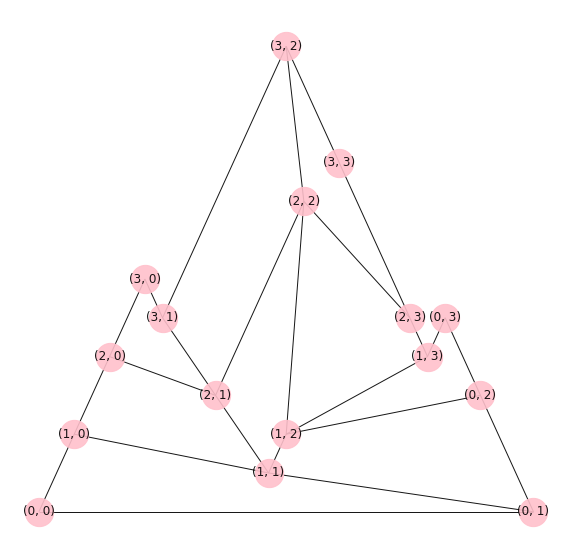

In [1419]:
graph = nx.grid_2d_graph(4,4)


plt.figure(figsize=(10,10))    # pour définir la taille de la figure
pos = nx.planar_layout(graph)
nx.draw_networkx(graph,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
plt.axis('off')
plt.show()


In [1429]:
node_list = list(graph.nodes)
trip1 = nx.shortest_path( graph, random.choice(node_list), random.choice(node_list))
trip2 = nx.shortest_path( graph, (1, 3), (1, 0))
print(trip2)
trip3 = nx.shortest_path( graph, (1, 0), (2, 3))
trip4 = list(((2,2),(1,2),(0,2),(1,1)))
trip5 = list(((3,2),(2,2),(2,3),(1,3),(0,3),(0,2)))
print("\n trip1:",trip1,"\n trip2:",trip2,"\n trip3:",trip3,"\n trip4:",trip4, "\n trip5:",trip5 )

[(1, 3), (1, 2), (1, 1), (1, 0)]

 trip1: [(1, 3), (1, 2), (1, 1), (1, 0), (2, 0)] 
 trip2: [(1, 3), (1, 2), (1, 1), (1, 0)] 
 trip3: [(1, 0), (1, 1), (1, 2), (1, 3), (2, 3)] 
 trip4: [(2, 2), (1, 2), (0, 2), (1, 1)] 
 trip5: [(3, 2), (2, 2), (2, 3), (1, 3), (0, 3), (0, 2)]


In [1430]:
agentList = [RiderAgent(0,(1, 1),(1, 3)), DriverAgent(1, trip1), DriverAgent(2, trip2), DriverAgent(3, trip3), DriverAgent(4, trip4), DriverAgent(5, trip5)]
sma = SMA(agentList, graph)
sma.runOnce()



 driver node tracker : {(0, 0): [], (0, 1): [], (0, 2): [(4, [(0, 2), (1, 1)], 2)], (0, 3): [(5, [(0, 3), (0, 2)], 4)], (1, 0): [(1, [(1, 0), (2, 0)], 3), (3, [(1, 0), (1, 1), (1, 2), (1, 3), (2, 3)], 0)], (1, 1): [(1, [(1, 1), (1, 0), (2, 0)], 2), (2, [(1, 1), (1, 0)], 2), (3, [(1, 1), (1, 2), (1, 3), (2, 3)], 1)], (1, 2): [(1, [(1, 2), (1, 1), (1, 0), (2, 0)], 1), (2, [(1, 2), (1, 1), (1, 0)], 1), (3, [(1, 2), (1, 3), (2, 3)], 2), (4, [(1, 2), (0, 2), (1, 1)], 1)], (1, 3): [(1, [(1, 3), (1, 2), (1, 1), (1, 0), (2, 0)], 0), (2, [(1, 3), (1, 2), (1, 1), (1, 0)], 0), (3, [(1, 3), (2, 3)], 3), (5, [(1, 3), (0, 3), (0, 2)], 3)], (2, 0): [], (2, 1): [], (2, 2): [(4, [(2, 2), (1, 2), (0, 2), (1, 1)], 0), (5, [(2, 2), (2, 3), (1, 3), (0, 3), (0, 2)], 1)], (2, 3): [(5, [(2, 3), (1, 3), (0, 3), (0, 2)], 2)], (3, 0): [], (3, 1): [], (3, 2): [(5, [(3, 2), (2, 2), (2, 3), (1, 3), (0, 3), (0, 2)], 0)], (3, 3): []}

 ad : {(1, 1): [(1, [(1, 1), (1, 0), (2, 0)], 2), (2, [(1, 1), (1, 0)], 2), (3, [(

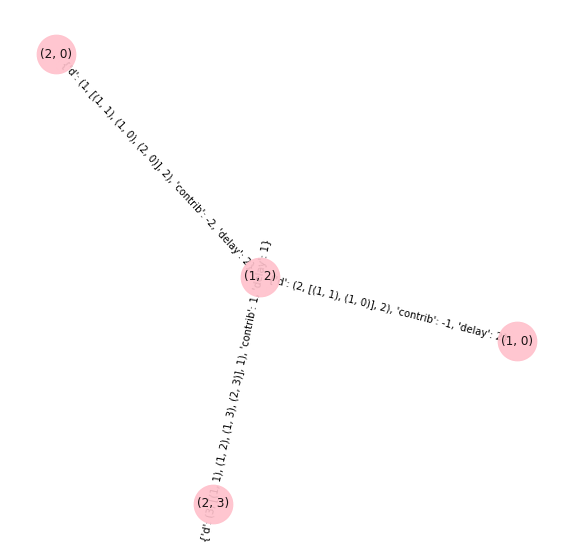

{(2, 0): 3, (1, 0): 2, (2, 3): 3, (1, 2): 0}


In [1431]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[0].G_ts
pos = nx.spring_layout(G_ts)
#labels = nx.get_node_attributes(G_ts, 'distance') 
nx.draw_networkx(G_ts,pos=pos, edge_color='black',width=1,linewidths=1,node_size=1500,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
#nx.draw_networkx_labels(G_ts,pos=nx.spring_layout(G_ts),labels=labels)
plt.axis('off')
plt.show()
print( nx.get_node_attributes(G_ts, 'distance') )

In [1432]:
sma.runOnce()


 driver node tracker : {(0, 0): [], (0, 1): [], (0, 2): [(4, [(0, 2), (1, 1)], 1)], (0, 3): [(5, [(0, 3), (0, 2)], 3)], (1, 0): [(1, [(1, 0), (2, 0)], 2)], (1, 1): [(1, [(1, 1), (1, 0), (2, 0)], 1), (2, [(1, 1), (1, 0)], 1), (3, [(1, 1), (1, 2), (1, 3), (2, 3)], 0)], (1, 2): [(1, [(1, 2), (1, 1), (1, 0), (2, 0)], 0), (2, [(1, 2), (1, 1), (1, 0)], 0), (3, [(1, 2), (1, 3), (2, 3)], 1), (4, [(1, 2), (0, 2), (1, 1)], 0)], (1, 3): [(3, [(1, 3), (2, 3)], 2), (5, [(1, 3), (0, 3), (0, 2)], 2)], (2, 0): [], (2, 1): [], (2, 2): [(5, [(2, 2), (2, 3), (1, 3), (0, 3), (0, 2)], 0)], (2, 3): [(5, [(2, 3), (1, 3), (0, 3), (0, 2)], 1)], (3, 0): [], (3, 1): [], (3, 2): [], (3, 3): []}

 ad : {(1, 2): [(1, [(1, 2), (1, 1), (1, 0), (2, 0)], 0), (2, [(1, 2), (1, 1), (1, 0)], 0), (3, [(1, 2), (1, 3), (2, 3)], 1), (4, [(1, 2), (0, 2), (1, 1)], 0)], (2, 0): [], (1, 0): [(1, [(1, 0), (2, 0)], 2)], (2, 3): [(5, [(2, 3), (1, 3), (0, 3), (0, 2)], 1)]}
{(1, 2): {'distance': 0}, (2, 0): {'distance': 3}, (1, 0): {'

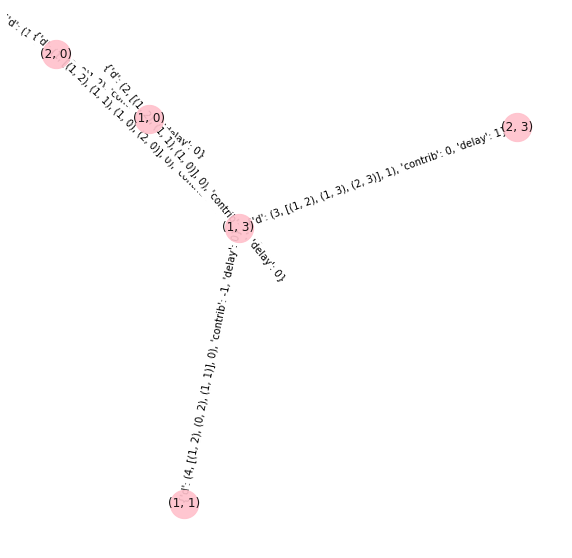

In [1433]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[0].G_ts
pos = nx.spring_layout(G_ts)
nx.draw_networkx(G_ts,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
plt.axis('off')
plt.show()


Il a l'air de bien arriver à (1,3) donc ça marche pas trop mal, l'affichage est pourri par contre...

In [1425]:
#version si jamais ça marche pas
import itertools

scores_paths = dict()
cur_node = (1,1)
other_nodes = [node for node in list(G_ts.nodes()) if node != cur_node]
paths = nx.all_simple_paths(G_ts, source=cur_node, target=other_nodes)

#heuristique : suivre le chemin qui rapporte le plus de cases le plus rapidement possible
for path in paths :
    id_d = None
    score_path = 0
    print(path)
    for i in range(len(path)):
        
        if i+1<len(path):
            data = G_ts.get_edge_data(path[i], path[i+1])
            print(data)
            
            #si il y a plusieurs arretes menants au meme noeuds
            if len(data) > 1:
                best_score = None
                #on est dans un multigraph, donc on prends la meilleur edge
                for j in range(len(data)):
                    cur_score = data[j]['contrib'] - data[j]['delay']
                    if best_score == None or best_score < cur_score:
                        best_score = cur_score
                        if i==0 :
                            id_d = data[j]['idd']
                        
                score_path += best_score
                
                    
            else :
                if i==0:
                    id_d =  data[0]['idd']
                score_path += data[0]['contrib'] - data[0]['delay']
        else :
            break
            
        scores_paths[id_d]=score_path
bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
random.shuffle(bests_d)
print(bests_d)
for d in sma.agentList[0].Ad[cur_node]:
    if d[0] in bests_d:
        print(d)
        
        

ValueError: max() arg is an empty sequence

In [1221]:

import itertools

scores_paths = dict()
cur_node = (1,1)
other_nodes = [node for node in list(G_ts.nodes()) if node != cur_node]
paths = nx.all_simple_paths(G_ts, source=cur_node, target=other_nodes)

#heuristique : suivre le chemin qui rapporte le plus de cases avec le moins de temps d'attente
for path in paths :
    d = None
    score_path = 0
    print(path)
    for i in range(len(path)):
        
        if i+1<len(path):
            data = G_ts.get_edge_data(path[i], path[i+1])
            print(data)
            
            #si il y a plusieurs arretes menants au meme noeuds
            
            best_score = None
            #on est dans un multigraph, donc on prends la meilleur edge
            for j in range(len(data)):
                cur_score = data[j]['contrib'] - data[j]['delay']
                if best_score == None or best_score < cur_score:
                    best_score = cur_score
                    if i==0 :
                        d = data[j]['d']
                        
            score_path += best_score                   
            
        else :
            break
    
    scores_paths[d]=score_path

bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
random.shuffle(bests_d)
print(bests_d)
for d in bests_d :
    if d[2]==0:
        print(ad)
            

[(1, 1), (1, 0)]
{0: {'idd': 2, 'contrib': -1, 'delay': 1}}


KeyError: 'd'

In [1165]:
print(sma.agentList[0].Ad[cur_node][0][2])

1


In [1168]:
for ad in sma.agentList[0].Ad[cur_node] :
    print(ad[2])

1
0


In [1202]:
##### scores_paths[5]=2
bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
bests_d

ValueError: max() arg is an empty sequence

In [1150]:
scores_paths

{2: -2, 3: 2, 5: 2}

In [1136]:
scores = dict()
cur_node = (1,1)
other_nodes = [node for node in list(G_ts.nodes()) if node != cur_node]
paths = list(nx.all_simple_paths(G_ts, source=cur_node, target=other_nodes))
paths

[[(1, 1), (1, 0)], [(1, 1), (1, 3)]]

In [1071]:
nx.all_simple_paths(G_ts, source=(2,2), target=list(G_ts.nodes())[1:])

TypeError: not all arguments converted during string formatting

In [970]:
G_ts.get_edge_data((1, 1), (1, 0))[0]['contrib']

-1

[(1, 0), (1, 3), (0, 2)]

In [921]:
nx.all_simple_paths(G_ts, source=G_ts.nodes(1,1), target=G_ts.nodes())

NodeNotFound: source node [((1, 1), 1), ((1, 0), 1), ((1, 3), 1), ((0, 2), 1)] not in graph

# OLD
tout ce qui est au dessus me semble ok
je conserve le reste pour archive pour l'instant, et il y a le generateur qui etait pas mauvais normalement

In [ ]:
import random

class CarAgent():
    global bounds
    def __init__(self, unique_id, pos_dep):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.is_alive = True
        
    def update(self):
        direction = random.randrange(4)
        if direction == 0:
            self.new_pos = (self.pos[0]+1,self.pos[1])#EST
        elif direction == 1:
            self.new_pos = (self.pos[0],self.pos[1]-1)#SUD
        elif direction == 2:
            self.new_pos = (self.pos[0]-1,self.pos[1])#OUEST
        else :
            self.new_pos = (self.pos[0],self.pos[1]+1)#NORD

        # on vérifie que la nouvelle position est bien dans les limites de l'environnement sinon l'agent meurt
        if bounds[0]<=self.new_pos[0] or self.new_pos[0] <0 or  bounds[1]<=self.new_pos[1] or self.new_pos[1]<0:
            #global agentList
            #agentList.remove(self) # on ne peut pas faire ça sinon l'agent suivant remplace l'agent courant
            self.is_alive = False
            print("agent "+str(self.unique_id)+ " died")

    def decide(self):
        if self.is_alive == True :
            if self.pos == self.new_pos:
                print("Agent voiture n°",self.unique_id,"apparait en",self.pos)
            else :
                print("Agent voiture n°",self.unique_id,"bouge de",self.pos,"à",self.new_pos)
                self.pos = self.new_pos
        

In [ ]:
bounds = (10,10)
agentList = [CarAgent(1,(0,0)) , CarAgent(2,(5,5)), CarAgent(3,(8,8))]
tick = 0
for _ in range(10):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
        
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            random.shuffle(agentList)
            agentList.remove(a) 
    print("tick",tick,"ended\n")
    tick+=1
        

In [ ]:
class RiderAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.pos_arr = pos_arr
        self.waiting_time = 0
        self.is_alive = True

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None

    def update(self):
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        global agentList
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def decide(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
            #on vérifie si le passager est arrivé à destination
            if self.pos == self.pos_arr:
                print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
                self.is_alive = False
        else :
            self.waiting_time += 1

# A ton besoin de simultanéité ?
Voici un petit bout de code permettant de prouver le besoin de simultanéité, en effet comme précisé plus haut, si l'on donne le tour de parole aléatoirement au agents, il se peu qu'un agent effectue deux fois son tour de parole d'affilé :

type de config :

--tick 0
agent 1 puis agent 2


--tick 1
agent 2 puis agent 1

In [ ]:
bounds = (10,10)
agentList = [CarAgent(1,(0,0)) , CarAgent(2,(5,5)), CarAgent(3,(8,8)), RiderAgent(4,(5,5),(5,9))]
tick = 0
for _ in range(10):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
        
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            random.shuffle(agentList)
            agentList.remove(a) 
    print("tick",tick,"ended\n")
    tick+=1
        

### Les générateurs de véhicules

Afin d'avoir un flux continu de véhicules, il est nécessaire de générer de nouveaux véhicules régulièrement. c'est le role des agents `Generator`.

In [ ]:
import random

class Generator() :
    global bounds
    global tick
    def __init__(self, unique_id, frequence, nb_cars):
        self.unique_id = unique_id
        self.frequence = frequence #generation tout les "frequence" ticks
        self.nb_cars = nb_cars
        self.is_alive = True
        
    def update(self): 
        if tick == 0 or (self.frequence % tick) :
            genList = []
            for _ in range(self.nb_cars):
                global id_count
                id_count += 1
                genList.append(CarAgent(id_count, (random.randrange(bounds[0]),random.randrange(bounds[1]))))
            
            global agentList
            agentList = agentList + genList
        else:
            pass
    
    def decide(self):
        pass
    

In [ ]:
bounds = (10,10)
agentList = []
id_count = 0
tick = 0
gen = Generator(0, 5, 5)
agentList = [gen]
for _ in range(5):
    random.shuffle(agentList)
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1

In [ ]:
class RiderAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.pos_arr = pos_arr
        self.waiting_time = 0
        self.is_alive = True

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None

    def update(self):
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        global agentList
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def decide(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
            #on vérifie si le passager est arrivé à destination
            if self.pos == self.pos_arr:
                print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
                self.is_alive = False
        else :
            self.waiting_time += 1

# A ton besoin de simultanéité ?
Voici un petit bout de code permettant de prouver le besoin de simultanéité, en effet comme précisé plus haut, si l'on donne le tour de parole aléatoirement au agents, il se peu qu'un agent effectue deux fois son tour de parole d'affilé :

type de config :

--tick 0
agent 1 puis agent 2


--tick 1
agent 2 puis agent 1

In [ ]:
bounds = (10,10)
agentList = [RiderAgent(0, (5,5), (5,0)),]
tick = 0


agentList = [gen]
for _ in range(5):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1


On a une grille. Un générateur de véhicules qui génère selon une loi de probabilité des véhicules sur l'un des axes dans l'un des sens. Simultanément apparaissent des passagers à un lei aléatoire pour une destination aléatoire (X,Y).
Les véhicules sont réputés toujours aller jusqu'au bout d'un axe et peuvent descendre un passager où ils veulent (c'est un bus ou un train). Le système est rythmé par unités de temps (ticks). Avancer d'une case prend 1 tick, et donc attendre un véhicule qui est 2 cases plus loin prend 2 ticks.


## Le SMA

In [ ]:
import random
class SMA:
    def __init__(self, bounds):
        self.tick=0
        self.resetTicks()
        self.agentList = []
        #self.gen = gen # on associe le générateur au sma, c'est plus simple
        self.bounds = bounds
        self.collector = [] # on collecte ici les temps d'attente

    def resetTicks(self):
        tick=0
          
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        for i in range(0,rounds):
            self.runOnce()
    
    def runOnce(self):
        self.tick+=1
        gen.generate_agent()
        random.shuffle(self.agentList)
        #on calcule les prochains positions des voitures
        for ag in self.agentList :
            ag.cars_new_pos()
        #on determine si les passagers vont bouger ou non
        for ag in self.agentList :
            ag.riders_new_pos()
        #on actualise la position des agents
        for ag in self.agentList :
            ag.agents_update_pos()
            
        #print("tick "+str(self.tick)+" ended")

In [ ]:
#bounds = (10,10)
#agentList = []
#id_count = 0
#tick = 0
gen = Generator(0, 5, 5)
agentList = [gen]
for _ in range(5):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1

## L'environnement


Au final, on a pas du tout besoin d'une grille, dans le sens ou on l'on peut fonctionner juste avec les coordonnées des agents dans l'espace.

## Les agents

In [ ]:
class Agent:
    """ Pour pouvoir manipuler facilement les agents dans le sma, on creer une sorte d'abstract class """

    def __init__(self, unique_id: int, dep: (int, int), dest: (int,int)) -> None:
        self.unique_id = unique_id
        self.pos = dep
        self.pos_arr = dest
        self.new_pos = self.pos
    
    def cars_new_pos(self) -> None:
        pass

    def riders_new_pos(self) -> None:
        pass

    def agents_update_pos(self) -> None:
        pass

### Les véhicules

In [ ]:
class CarAgent(Agent):
    def __init__(self, unique_id, pos_dep, pos_arr):
        super().__init__(unique_id, pos_dep, pos_arr)
        
    def move(self):
        if self.pos[0] == self.pos_arr[0]:
            if self.pos[1] == self.pos_arr[1]:
                #print("Agent voiture n°",self.unique_id," arrivée à destination.")
                sma.agentList.remove(self)
                return
            elif self.pos[1] > self.pos_arr[1]:
                new_position = (self.pos[0],self.pos[1]-1)
            else : 
                new_position = (self.pos[0],self.pos[1]+1)
        elif self.pos[0] > self.pos_arr[0]:
            new_position = (self.pos[0]-1,self.pos[1])
        else : 
            new_position = (self.pos[0]+1,self.pos[1])
        
       
        self.new_pos = new_position
        
        
        
    def cars_new_pos(self):
        self.move()

    def riders_new_pos(self):
        pass

    def agents_update_pos(self):
        #print("Agent voiture n°",self.unique_id," bouge de ",self.pos," à ",self.new_pos)
        self.pos = self.new_pos

Les véhicules vont donc uniquement dans une direction, à chaque ticks ils regardent dans quel sens ils sont sensé aller et bougent d'une case.

### Les passagers

In [ ]:
class RiderAgent(Agent):
    def __init__(self, unique_id, pos_dep, pos_arr):
        super().__init__(unique_id, pos_dep, pos_arr)
        self.waiting_time = 0

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None
    
    def cars_new_pos(self):
        pass

    def riders_new_pos(self):
        if self.pos == self.pos_arr:
            #print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
            sma.collector.append(self.waiting_time)
            sma.agentList.remove(self)
            return
        
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        caragent = [agent for agent in sma.agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def agents_update_pos(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
        else :
            self.waiting_time += 1

A chaque tour, les agents passagers collectent le ou les agents voiture présent sur sa case, et prends celui qui va dans sa direction.

## Les générateurs de véhicules

In [ ]:
# Mettre ici le code d'un générateur trivial
import random
class Generator():
    def __init__(self, height, width, nb_car_x, nb_car_y, nb_rider):
        self.height = height
        self.width = width
        self.nb_car_x = nb_car_x
        self.nb_car_y = nb_car_y
        self.nb_rider = nb_rider
        self.n_id = -1
    
    def next_id(self):
        self.n_id += 1
        return self.n_id
    
    #genere les agents voitures a l'horizontal
    def XAgentGenerator(self):
        x = random.choice([0, self.width - 1])
        y = random.randrange(self.height)
        pos_dep = (x, y)
        pos_arr = (abs(x - self.width + 1), y)

        a = CarAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)
        
        
    #genere les agents voitures a la vertical
    def YAgentGenerator(self):
        x = random.randrange(self.width)
        y = random.choice([0, self.height - 1])
        pos_dep = (x, y)
        pos_arr = (x, abs(y - self.height + 1))

        a = CarAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)

    #genere les agents passagers a des positions aleatoire
    def RiderAgentGenerator(self):
        x = random.randrange(self.height)
        y = random.randrange(self.width)

        pos_dep = (x, y)
        x_p = random.randrange(self.height)
        y_p = random.randrange(self.width)
        pos_arr = (x_p, y_p)
        a = RiderAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)
    
    #fonction qui genere les agents en fonction des valeurs choisis
    def generate_agent(self):
       
        for _ in range(random.randrange(self.nb_car_x)):
            self.XAgentGenerator()
        for _ in range(random.randrange(self.nb_car_y)):
            self.YAgentGenerator()
        for _ in range(random.randrange(self.nb_rider)):
            self.RiderAgentGenerator()
    

# Une première version
Un passager est aveugle. Il monte dans le premier véhicule qui se présente dans sa direction (soit verticale soit horizontale) et il va jusqu'au maximum de sa possibilité (son X ou son Y de destination). Il se déplace dans une direction 1 fois, descend du véhicule, attend le prochain véhicule dans l'autre sens et arrive à sa destination.
Précisions :
- au maximum il attend 2 fois : au départ, et au changement
- grâce au rythme du système on est capable de tracer des courbes de temps d'attente (en tick)



In [ ]:
gen = Generator(10, 10, 5, 5, 5)
sma = SMA(gen)
sma.run(1000)


In [ ]:
import numpy as np
print("Le temps d'attente moyen est de",np.mean(sma.collector), "ticks")

Experience : faire varier le nombre de véhicule

In [ ]:
import matplotlib.pyplot as plt
range_vehicules = np.arange(5,50,5)
nb_passagers = 5

big_collector = []

for nb_vehicule in range_vehicules:
    gen = Generator(10, 10, nb_vehicule, nb_vehicule, 5)
    sma = SMA(gen)
    sma.run(1000)
    big_collector.append(np.mean(sma.collector))
    
plt.xlabel("Nombre de conducteur")
plt.ylabel("Nombre moyen de ticks d'attente")
plt.plot(range_vehicules,big_collector)

# Une version plus poussée

Le passager perçoit une partie de l'environnement : sa verticale et son horizontale. Quand un véhicule arrive dans sa case, il regarde le nombre de cases N que ce véhicule lui permet de faire (N=X ou N=Y), et si il y a dans sa perception un autre véhicule à T distance qui lui permettra d'avancer d'un nombre de cases U (dans l'autre direction), avec U-T > N alors il attend celui là (Corwin raisonne sur un "potentiel" : U-T c'est le potentiel de cases dans l'autre direction avec un taux de transfert 0).
Une fois dans le véhicule, le passager fait ce raisonnement là à chaque case, et donc, décide de descendre ou pas, pour en attendre un autre.
Précisions :
- la formule de choix mise en place pourrait être inversée ! c'est une heuristique ! Il y a des heuristiques optimistes et des heuristiques pessimistes (ne serait-ce qu'en inversant l'inégalité).
- Dans cette version le passager peut donc voyager en zig-zag, néanmoins il ne "dépasse" jamais son X et son Y.


# Bibliographie

Philippe Mathieu, Yann Secq.
Environment Updating and Agent Scheduling Policies in Agent-based Simulators. 
ICAART Conference, 2012, pp 170-175

Philippe Mathieu, Sébastien Picault, Yann Secq.
Design Patterns for Environments in Multi-agent Simulations. 
PRIMA Conference, 2015, pp 678-686

Philippe Mathieu, Gildas Morvan, Sébastien Picault.
Multi-level agent-based simulations: Four design patterns. 
Journal of Simulation Modelling Practice and Theory, Janv 2018
